## Problem Statement

### Context


AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help


### Objective

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.


###  Data Description

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

**Data Dictionary**

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of Visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

## Importing necessary libraries and data

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)
#%load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

## Read the dataset

In [2]:
# loading the dataset
data = pd.read_excel("Credit-Card-Customer-Data.xlsx")

In [3]:
df = data.copy()

## Data Overview

- Observations
- Sanity checks

In [4]:
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [5]:
df.shape

(660, 7)

* The data contains 660 rows and 7 columns

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


* The dataset consists of all integers

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


* The average credit limit ranges from 3,000 to 200,000, the 75th percentile and the max are huge differences
* The total visits online has a max of 15 with an 75th percentile of 4 which is a big difference
* Total calls made ranges between 0 and 10
* Total visits bank ranges 0 to 5
* Total credit cards ranges from 1 to 10

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

### Univariate Analysis

In [8]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [9]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### How is the distrubution of average credit limit of customer?

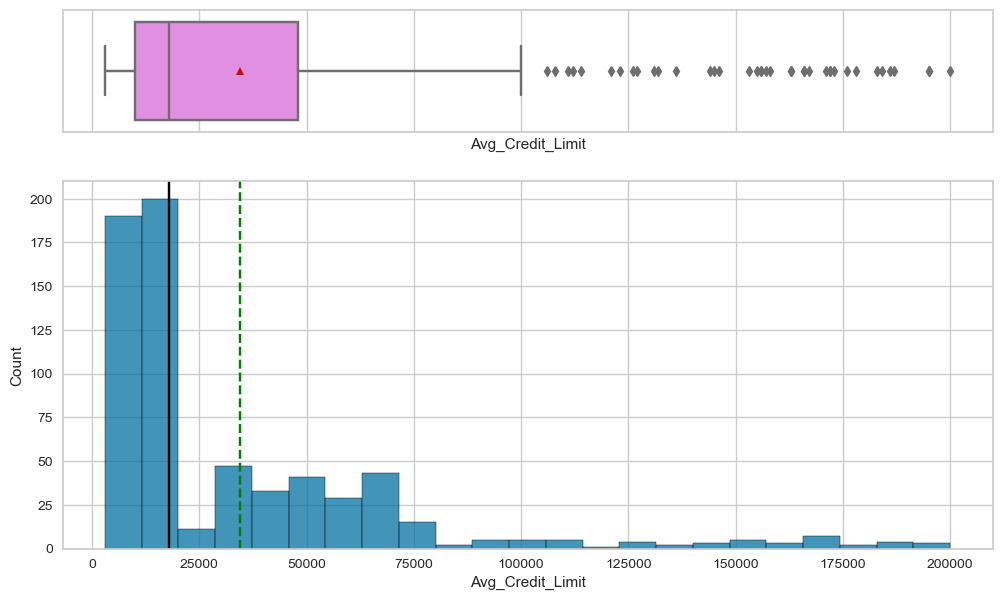

In [10]:
histogram_boxplot(df, "Avg_Credit_Limit")

* The distribution is extremely left skewed and contains many outliers. 

### What percentage of the customers have never made a service-related call to the bank?

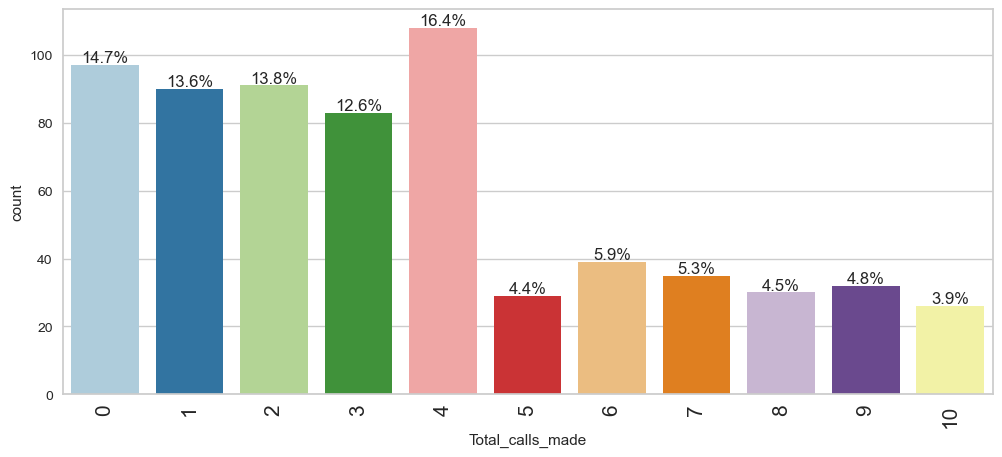

In [11]:
labeled_barplot(df, "Total_calls_made", perc=True)

* 14.7% of customers have never made a service-related call to the bank

### What percentage of customers have never logged in to the online portal?

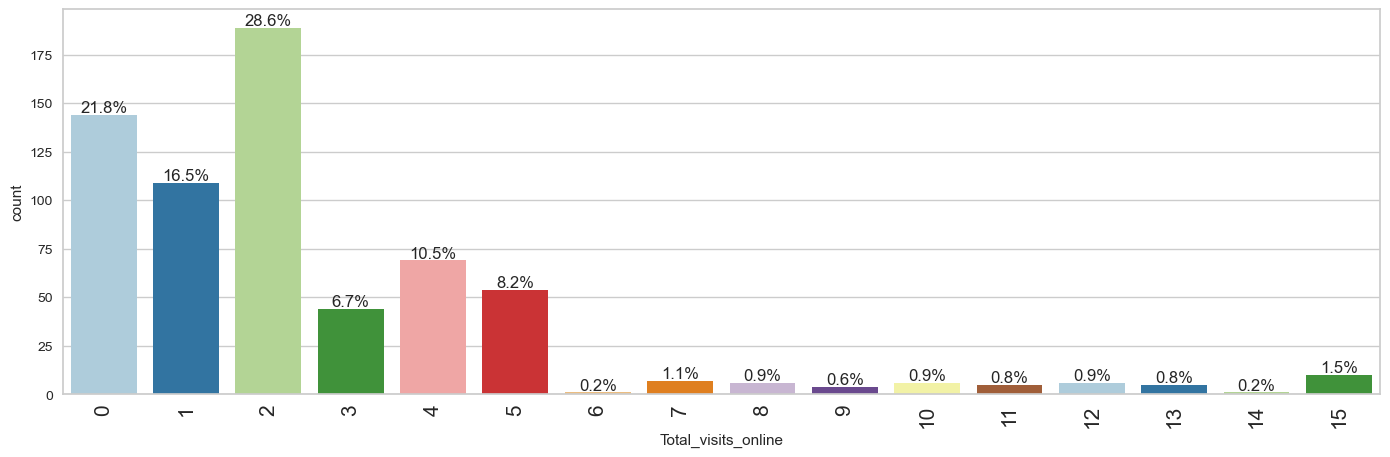

In [12]:
labeled_barplot(df, "Total_visits_online", perc=True)

* 21.8% of customers have never logged into the online portal

### How many customers have never visited bank?

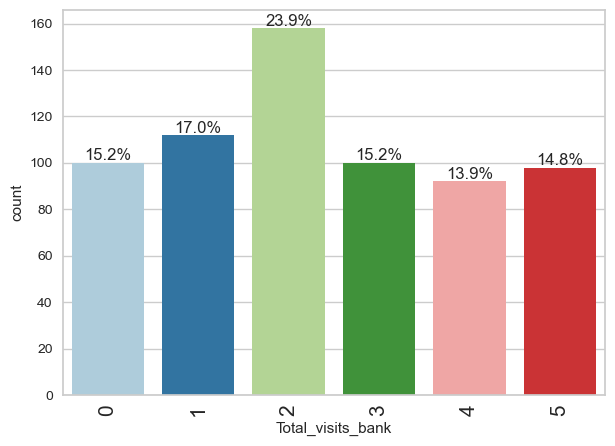

In [13]:
labeled_barplot(df, "Total_visits_bank", perc=True)

* 15.2% of customers have never visited the bank

### How are the different variables correlated with each other?

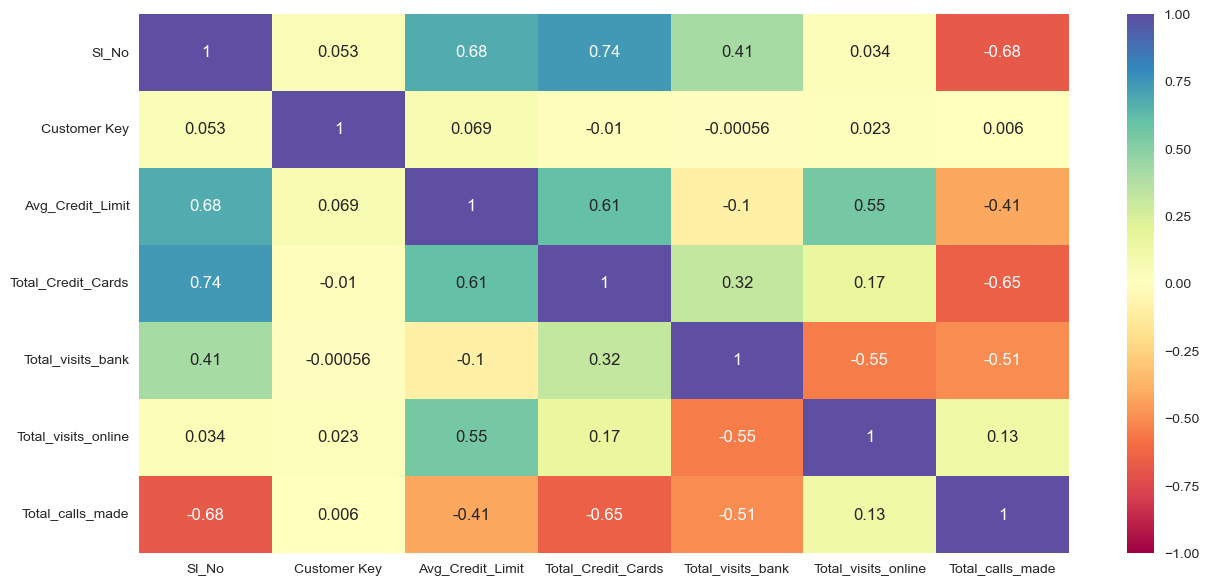

In [14]:
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, cmap="Spectral")
plt.show()

* Total Credit Cards and Total_visits_bank share above average correlation with the Average Credit Limit, so it appears as that the more credit cards that you have and the more times that you visit a bank the likelihood of your credit limit will increase
* Total_visits_bank and Total_visits_online showcase that the more times that you visit each one the less likely the other one will occur

## Data Preprocessing



- Duplicate value check
- Missing value treatment
- Outlier check
- Feature engineering (if needed)
- Any other preprocessing steps (if needed)

In [15]:
df.drop(['Sl_No', 'Customer Key'], axis=1, inplace=True)

In [16]:
df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


### Check for null values

In [19]:
df.isnull().sum()

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

### Scale the data

In [47]:
sc = StandardScaler()
subset_scaled_df = pd.DataFrame(
    sc.fit_transform(df),
    columns=df.columns,
)
subset_scaled_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537,1.243885
1,0.410293,-0.787585,-1.473731,2.520519,1.891859,-1.356159
2,0.410293,1.058973,-0.860451,0.134290,0.145528,1.243885
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528,1.243885
4,1.740187,0.597334,-1.473731,3.202298,-0.203739,-0.056137


## K-means Clustering

In [21]:
subset_scaled_df.columns

Index(['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made'],
      dtype='object')

In [22]:
num_col = ["Avg_Credit_Limit", "Total_Credit_Cards", "Total_visits_bank", "Total_visits_online", "Total_visits_bank"]

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9908683849620168
Number of Clusters: 6 	Average Distortion: 0.9429882588535909
Number of Clusters: 7 	Average Distortion: 0.9094446577282349
Number of Clusters: 8 	Average Distortion: 0.8893053053720255


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

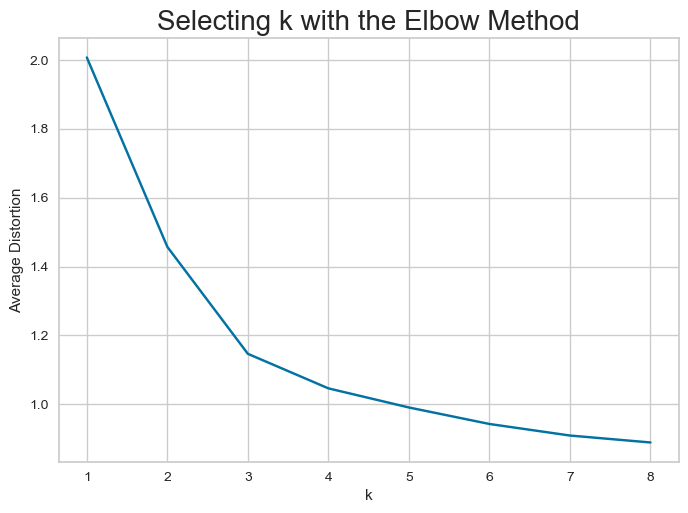

In [26]:
clusters = range(1, 9)
meanDistortions = []  # Create a empty list

for k in clusters:
    model = KMeans(n_clusters=k)  # Initialize KMeans
    model.fit(subset_scaled_df)  # Fit kMeans on the data
    prediction = model.predict(subset_scaled_df)  # Predict the model on the data
    distortion = (
        sum(np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1))
        / subset_scaled_df.shape[0]  # Find distortion
    )

    meanDistortions.append(
        distortion
    )  # Append distortion values to the empty list created above

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")  # Title of X-axis
plt.ylabel("Average Distortion")  # Title of y-axis
plt.title("Selecting k with the Elbow Method", fontsize=20)  # Title of the plot

In the above plot, the elbow is seen for K=2 and 3 but if you observe the Average distortion results, there is some drop in distortion at K=4

For n_clusters = 2, silhouette score is 0.41842496663215445
For n_clusters = 3, silhouette score is 0.5157182558881063
For n_clusters = 4, silhouette score is 0.3556670619372605
For n_clusters = 5, silhouette score is 0.27239829454176767
For n_clusters = 6, silhouette score is 0.255499043345148
For n_clusters = 7, silhouette score is 0.24876122710405577
For n_clusters = 8, silhouette score is 0.22676251882773146
For n_clusters = 9, silhouette score is 0.22367736404344407


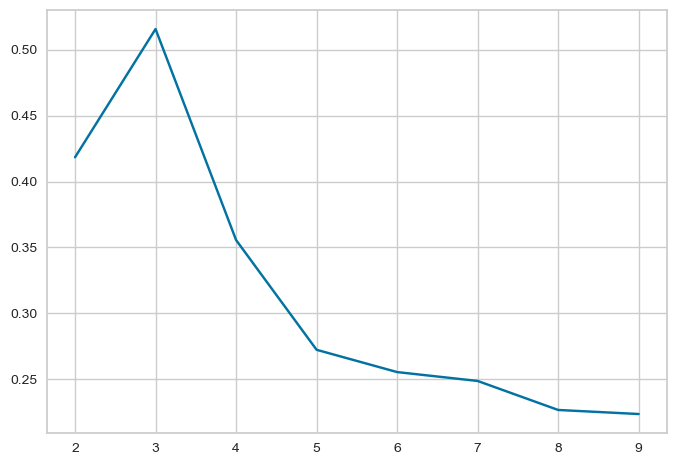

In [27]:
sil_score = []  # Create empty list
cluster_list = list(range(2, 10))  # Creating a list of range from 2 to 10
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)  # Initializing KMeans algorithm
    preds = clusterer.fit_predict((subset_scaled_df))  # Predicting on the data
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)  # Calculating silhouette score
    sil_score.append(score)  # Appending silhouette score to empty list created above
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

**From the silhouette scores, it seems that 4 is a good value of k. Let's do deeper investigation for different K values using  SilhouetteVisualizer**

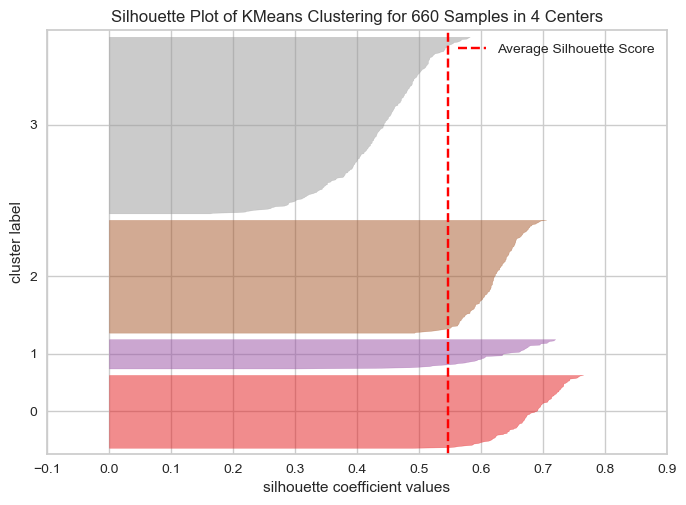

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [85]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

From the above plot, we can see that all the all the clusters have crossed Avg silhoutte score, all the clusters have different silhoutte score and have different width size, but the silhoutte score is very less. Let's visualize K=5.

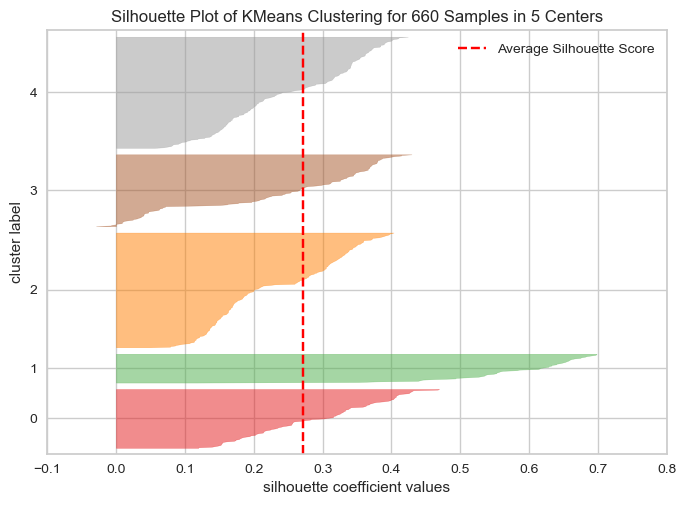

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [40]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

The above plot contains all the clusters with different silhoutee scores, different width sizes, and each cluster passing the average.

In [41]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=5, random_state=0)

In [75]:
# adding kmeans cluster labels to the original dataframe
df["K_means_segments"] = kmeans.labels_
subset_scaled_df["K_means_segments"] = kmeans.labels_

## Hierarchical Clustering

In [86]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.8484670054250267.
Cophenetic correlation for Euclidean distance and complete linkage is 0.9103369651254086.
Cophenetic correlation for Euclidean distance and average linkage is 0.9118805561270109.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8970752996856282.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7841550481660612.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.9004336009137507.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8741202858914554.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.9028793798563979.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.8546748822837158.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.54836650397478.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8473666089656766.
Cophenetic corr

In [87]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9118805561270109, which is obtained with Euclidean distance and average linkage.


In [88]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.8484670054250267.
Cophenetic correlation for complete linkage is 0.9103369651254086.
Cophenetic correlation for average linkage is 0.9118805561270109.
Cophenetic correlation for centroid linkage is 0.9104173504376633.
Cophenetic correlation for ward linkage is 0.7979655004741834.
Cophenetic correlation for weighted linkage is 0.8970752996856282.


In [89]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9118805561270109, which is obtained with average linkage.


We see that the cophenetic correlation is maximum with Euclidean distance and average linkage.

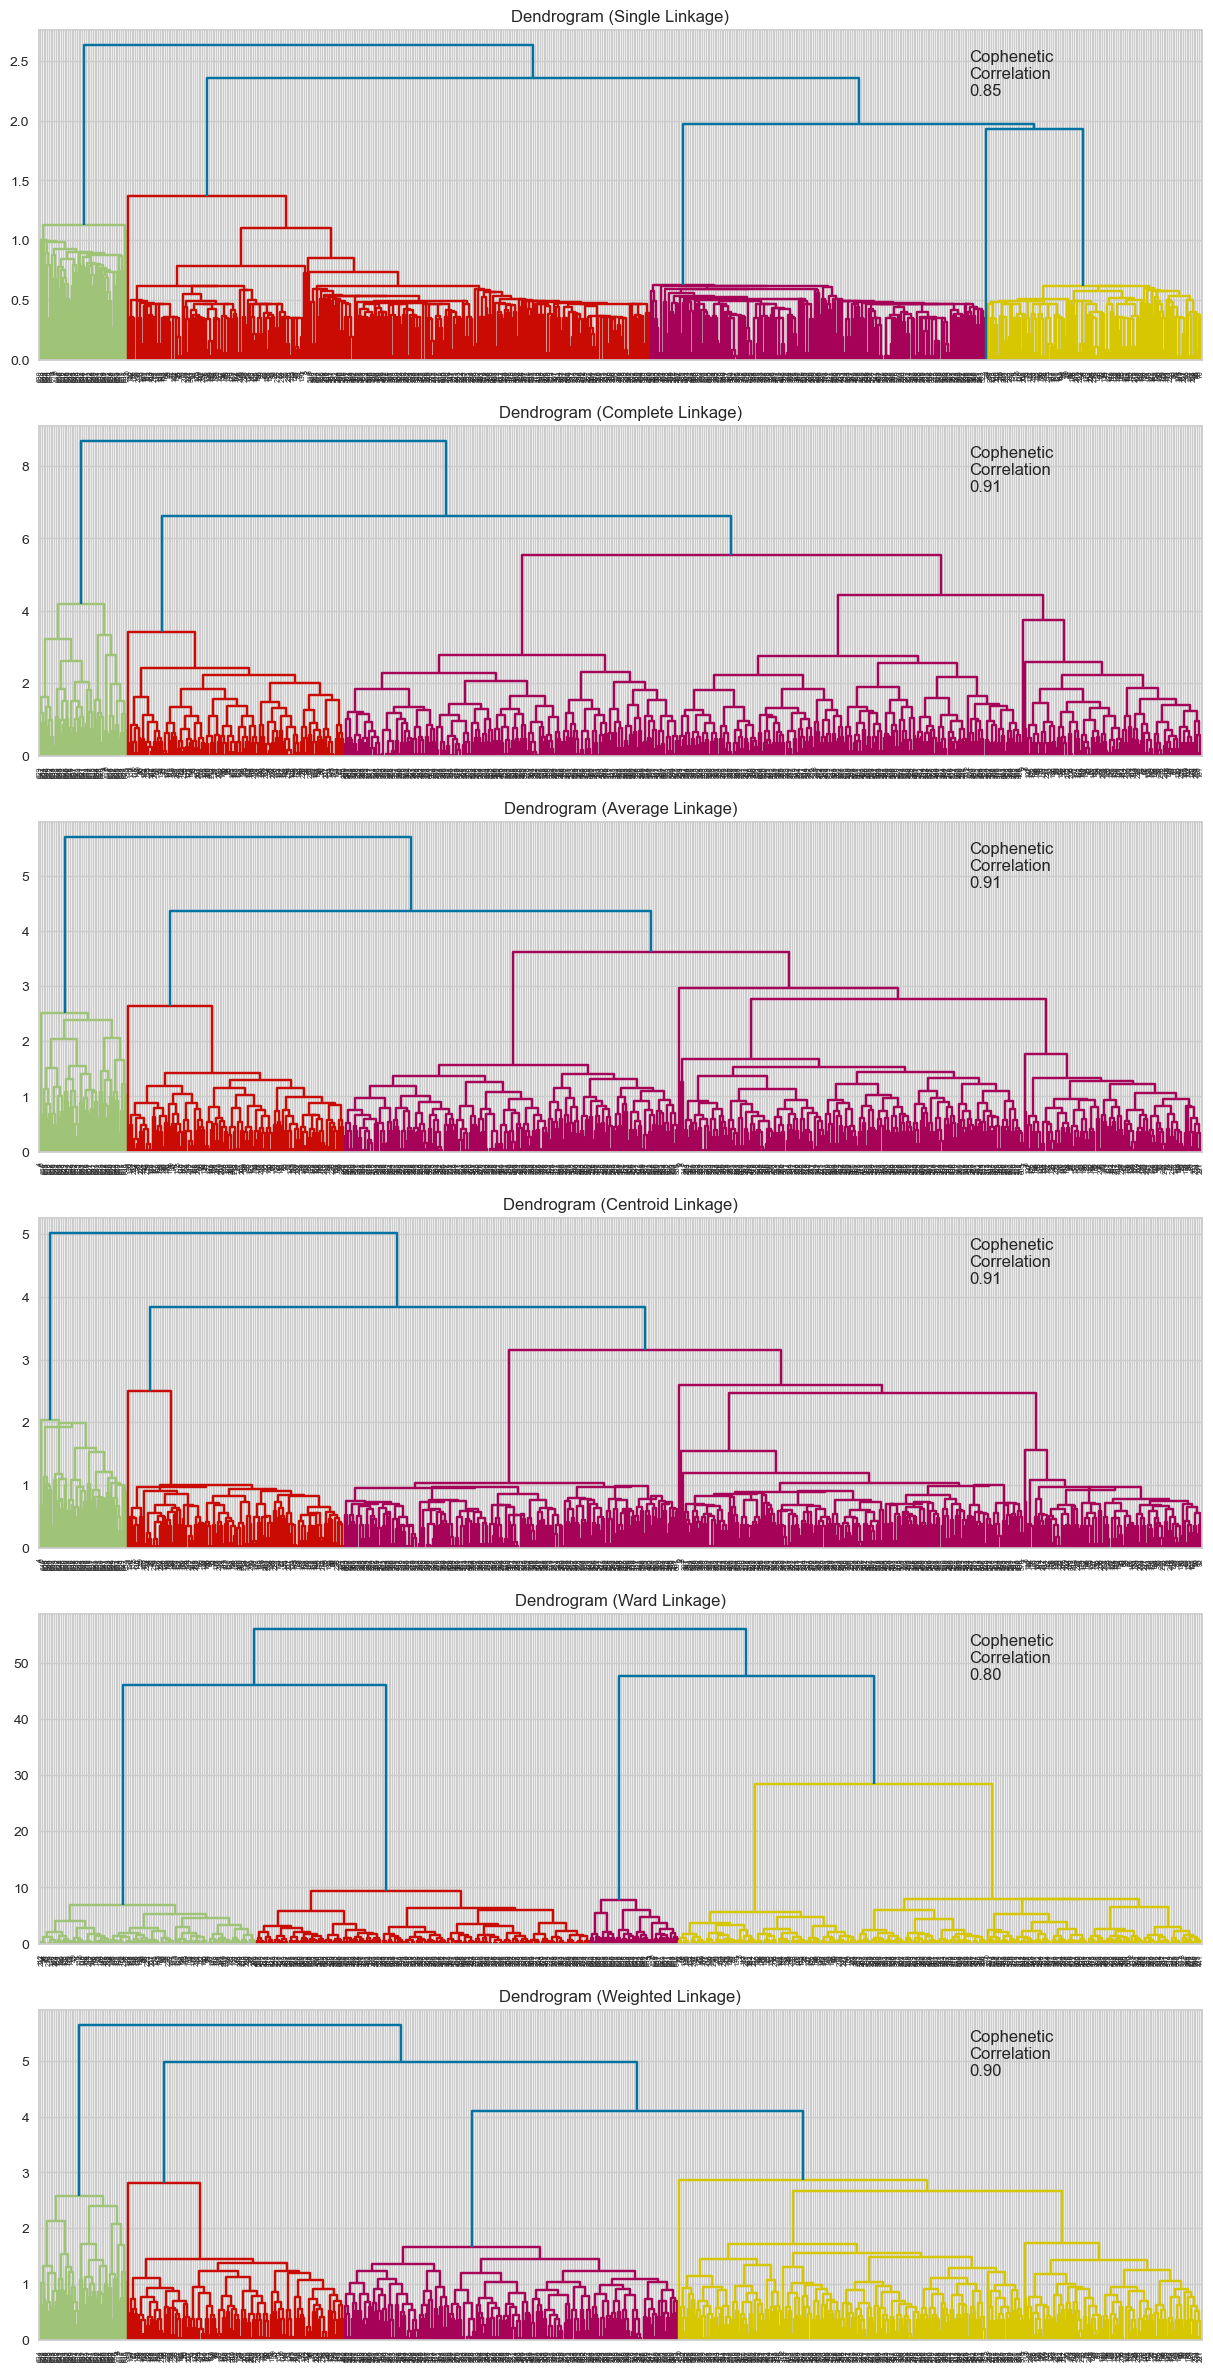

In [ ]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

* The cophenetic correlation is highest for average, centroid, and complete linkage methods.
* We will move ahead with average linkage.

In [92]:
HCmodel = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="average")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(linkage='average', n_clusters=4)

In [94]:
subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

## Cluster Profiling (K Means)

In [76]:
cluster_profile = df.groupby("K_means_segments").mean()

In [77]:
cluster_profile["count_in_each_segment"] = (
    df.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

In [78]:
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,12300.813008,2.357724,0.878049,3.626016,8.398374,123
1,31226.315789,5.478947,4.515789,1.010526,1.936842,190
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50
3,12019.801980,2.475248,1.000000,3.465347,5.009901,101
4,36260.204082,5.551020,2.494898,0.954082,2.061224,196


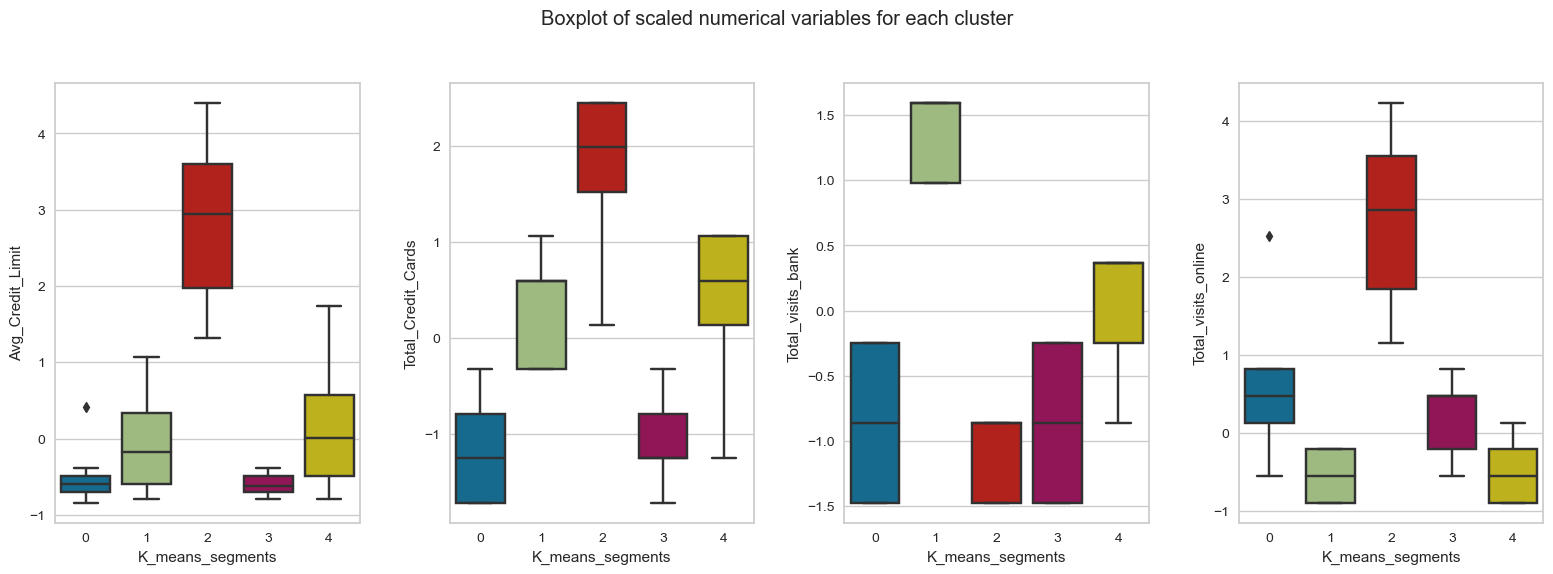

In [81]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster")
counter = 0
for ii in range(4):
    sns.boxplot(ax=axes[ii], y=subset_scaled_df[num_col[counter]], x=subset_scaled_df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

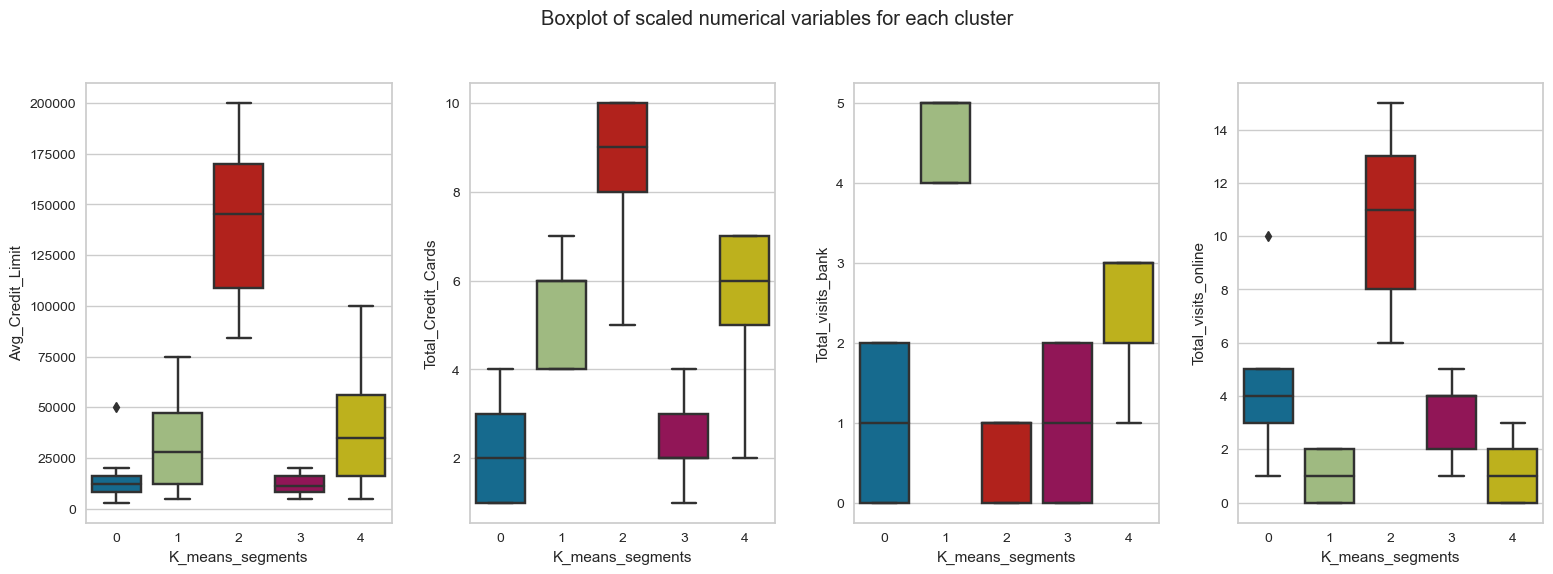

In [82]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster")
counter = 0
for ii in range(4):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

<AxesSubplot:xlabel='K_means_segments'>

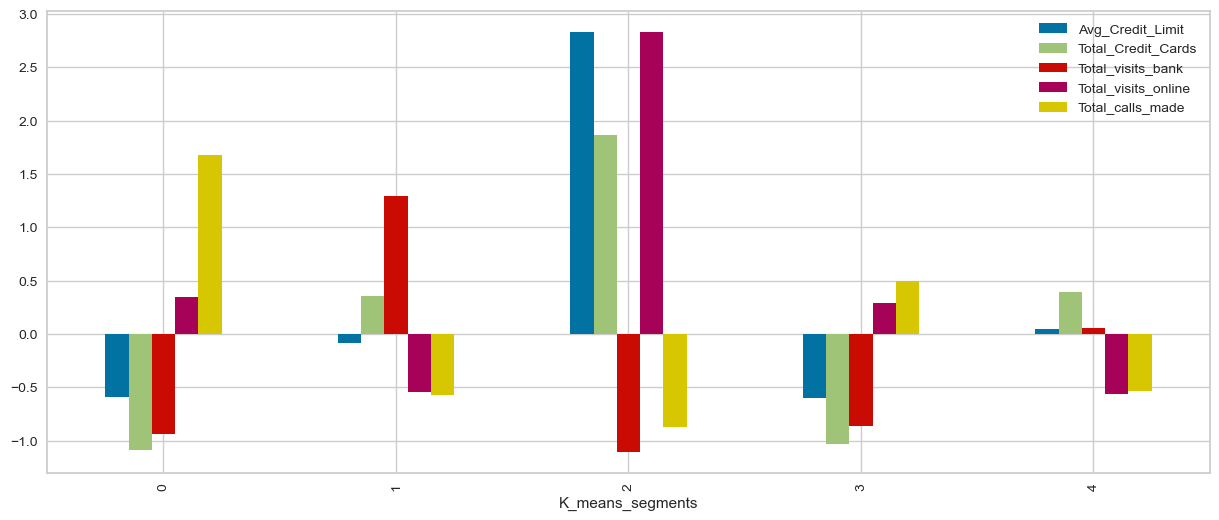

In [80]:
subset_scaled_df.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

## Cluster Profile (Hierarchical Clustering)

In [95]:
cluster_profile = df.groupby("HC_Clusters").mean()

In [96]:
cluster_profile["count_in_each_segments"] = (
    df.groupby("HC_Clusters")["Total_Credit_Cards"].count().values
)

In [97]:
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,count_in_each_segments
HC_Clusters,,,,,,,
0,28016.835017,4.505051,1.986532,1.808081,3.063973,3.659933,297
1,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,50
2,12300.813008,2.357724,0.878049,3.626016,8.398374,0.000000,123
3,31226.315789,5.478947,4.515789,1.010526,1.936842,1.000000,190


## Insights

- **Cluster 0**:
    - This cluster contains the one of the lowest medians for credit limits used for customers with the median being around $12,500
    - The median for total credit cards in this cluster is 2 which means that customers do not have a ton of credit spending power
    - Customers in this cluster do not visit the bank often
   
- **Cluster 1**:
    - Customers in this cluster have an median spending limit of 26,000
    - Customers in this cluster visit the bank often
    - A large portion of customers in this cluster have between 4 to 6 credit cards
    
- **Cluster 2**:
    - Customers in this cluster have the highest credit spending limit
    - More than 50% of customers have 8 to 10 credit cards in this cluster
    - Customers in this cluster do not visit the bank online often

- **Cluster 3**:
    - This cluster has an below average credit spending limit
    - The median for total bank visits is 1 
    - Customers in this cluster have the lowest total amount of credit cards
    
- **Cluster 4**:
    - This cluster has the second highest credit spending limit
    - Customers in this cluster have an median of 6 credit cards
    - Customers in this cluster visit the bank 2-3 times

## K-means vs Hierarchical Clustering

You compare several things, like:
- Which clustering technique took less time for execution?
- Which clustering technique gave you more distinct clusters, or are they the same?
- How many observations are there in the similar clusters of both algorithms?
- How many clusters are obtained as the appropriate number of clusters from both algorithms?

You can also mention any differences or similarities you obtained in the cluster profiles from both the clustering techniques.

* K Means took the least amount of time for executing
* Some of the clusters were similar in both of the different techniques
* There about 363 observations for the similar clusters in both algorithms
* About 9 clusters are obtained as the appropriate number of clusters from both algorithms

## Actionable Insights and Recommendations

* Customers who have an average of $141,040 in credit limits should be targeted for upselling through online campaigns, these customers are typically visiting the banking website more than any other customer and we also know they have a high amount of credit cards
* We should conduct surveys on the customers who make on average 8 calls to the customer support team here, these customers will give us more insight in how we're showing up as a team so that we can rectify any issues or hiccups in our process
* After we revamp our process from the feedback we get from existing customers on how we perform, we should also add surveys to the end of each customer support call so we can continously improve on our existing process
* We can also use the surveys on existing customers that enjoy our services that we provide to get feedback and to use the positive aspects of that feedback to incorprate in our marketing messages for gaining new clients. 